# Exploratory Data Analysis

## Initial Settings

### Roots and Paths

In [1]:
import sys
from pathlib import Path

# path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

### Libraries and Dependencies

In [2]:
import src.utils as ut
import src.config as cf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from IPython.display import display
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier


pd.options.display.max_columns = None
sns.set_style('dark')
sns.set_palette('dark')

project path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250503 Personal Medical Costs
raw data path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250503 Personal Medical Costs\data\raw_data.csv
model path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250503 Personal Medical Costs\models\model.pkl
results path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250503 Personal Medical Costs\results


### Data Loading

In [3]:
df = ut.load_data(cf.paths['data_raw'])

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
target = 'charges'

In [7]:
df = df.rename(columns = {'charges': 'target'})

## Preliminary EDA

### Basic Information

In [8]:
# dataset size
print(f'Dimensions: {df.shape}')

# summary table
ut.summary_info(df)

Dimensions: (1338, 7)


Column,Non-Null Count,Missing %,Unique Values,Data Type
age,"1,338",0.000000,47,int64
sex,"1,338",0.000000,2,object
bmi,"1,338",0.000000,548,float64
children,"1,338",0.000000,6,int64
smoker,"1,338",0.000000,2,object
region,"1,338",0.000000,4,object
target,"1,338",0.000000,"1,337",float64


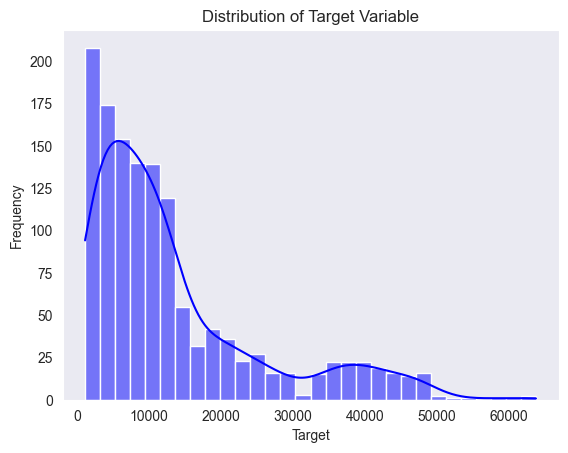

In [ ]:
# target distribution
sns.histplot(df['target'], kde=True, bins=30, color='blue')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

### Missing Values

In [11]:
ut.missing_values_by_pivot(df, return_type = 'percentage',percentage_base = 'total') 

,Missing %
age,0.0
sex,0.0
bmi,0.0
children,0.0
smoker,0.0
region,0.0
target,0.0


## Feature - Target Relevance Analysis

### Numerical Features Relevance

#### Feature - Target Correlations

Explore correlations for the numerical features vs target feature. The higher the absolute correlation, the better. This will give us an idea of the predictive power of the numerical variables

In [14]:
# target - numeric correlations
correlations = df.drop(['target'], axis = 1).select_dtypes(include = ['float64', 'int64']).corrwith(df['target'])
correlations = correlations.sort_values(ascending = False)

# show
print('Target Correlations:')
correlations_table = pd.DataFrame(correlations, columns = ['Correlation'])
correlations_table

Target Correlations:


,Correlation
age,0.299008
bmi,0.198341
children,0.067998


#### Feature - Target Correlation Visualization

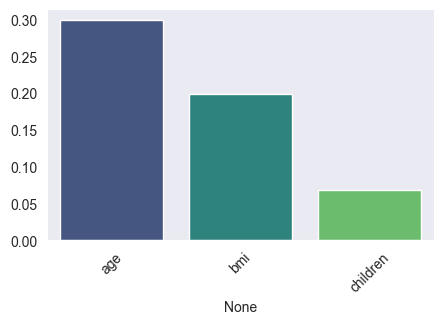

In [15]:
plt.figure(figsize = (5, 3))
sns.barplot(
    x = correlations.index, 
    y = correlations.values, 
    palette = 'viridis',
    hue = correlations.index,
    dodge = False)
plt.xticks(rotation = 45)
plt.show()

#### ANOVA Revelance Analysis

Numerical Features with p-value below 0.05 are more significant. This is modeled through a F-Statistic that measures the difference between groups in the target variable, relative to the inner dispersion

In [16]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns='target', errors='ignore').columns

anova_results = []

for col in numerical_cols:
    # calculate correlation and p-value
    correlation = df[col].corr(df['target'])
    f_stat, p_value = f_oneway(df[col], df['target'])
    
    # save results in a dictionary
    anova_results.append({'Feature': col, 'Correlation': correlation, 'F-Statistic': f_stat, 'P-Value': p_value})

# convert results to DataFrame
anova_table = pd.DataFrame(anova_results)

# formatting
anova_table = anova_table.sort_values(by='P-Value', ascending=True)

anova_table.style.format({
    'Correlation': '{:.3f}',
    'F-Statistic': '{:.2f}',
    'P-Value': '{:.3f}'
})

anova_table
    

,Feature,Correlation,F-Statistic,P-Value
2,children,0.067998,1606.441197,1.642423e-275
1,bmi,0.198341,1599.289412,1.538357e-274
0,age,0.299008,1597.224287,2.937027e-274


### Categorical Features Relevance

#### Categorical Features Selection

In [17]:
cat_columns = list(set(df.columns) - set(numerical_cols))

#### Chi - Squared Test

This test is to evaluate independence between two categorical features. We apply it to check if the categorical predictive features are independent to the categorical target feature. If the p-value is less than 0.05 it means that the features are NOT independent and the feature holds predictive power and it should be kept in the model

In [18]:
anova_results = []

for col in cat_columns:
    # Group the target variable by the categorical feature
    groups = [df[df[col] == category]['target'] for category in df[col].unique()]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Append results
    anova_results.append({'Feature': col, 'F-Statistic': f_stat, 'P-Value': p_value})

# Convert results to DataFrame
anova_df = pd.DataFrame(anova_results).sort_values(by='F-Statistic', ascending=False)

# Formatting
anova_df.style.format({
    'F-Statistic': '{:.2f}',
    'P-Value': '{:.3f}'
})

anova_df

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,Feature,F-Statistic,P-Value
1,target,inf,0.000000e+00
3,smoker,2177.614868,8.271436e-283
2,sex,4.399702,3.613272e-02
0,region,2.969627,3.089336e-02


### Feature Ranking

##### Preliminary Preprocessing

Small preliminary processing section. This is NOT the final preprocessing pipeline. It is used to prep the set to be used in a Random Forest model and evaluate feature relevance according to this model

In [19]:
df_encoded = df.copy()

for col in cat_columns:
    encoder = LabelEncoder()
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

df_encoded.head()

,age,sex,bmi,children,smoker,region,target
0,19,0,27.900,0,1,3,1005
1,18,1,33.770,1,0,2,57
2,28,1,33.000,3,0,2,306
3,33,1,22.705,0,0,1,1097
4,32,1,28.880,0,0,1,254


##### Target - Feature Split

In [20]:
X = df_encoded.drop(['target'], axis = 1)
y = df_encoded['target']

##### Simple Random Forest Fit

In [21]:
model = RandomForestClassifier(random_state = 123, n_estimators = 100)
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index = X.columns).sort_values(ascending = False)

##### Ranking Table

In [22]:
importance_df = pd.DataFrame({
    'Feature': feature_importance.index,
    'Importance': feature_importance.values
}).sort_values(by = 'Importance', ascending = False)

importance_df

,Feature,Importance
0,bmi,0.437355
1,age,0.334897
2,children,0.091139
3,region,0.072725
4,sex,0.036540
5,smoker,0.027344


##### Ranking Visualization

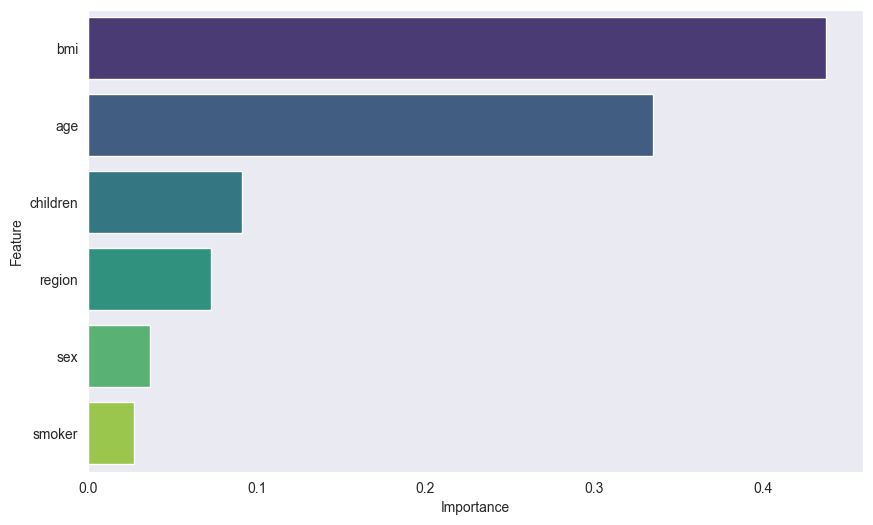

In [23]:
plt.figure(figsize = (10, 6))

sns.barplot(
    x = 'Importance', 
    y = 'Feature', 
    data = importance_df, 
    palette = 'viridis',
    hue = 'Feature',
    dodge = False)
plt.show()

### Relevant Feature Selection

From the previous analyses, we can form an educated opinion on relevant features and explore those
This approach is useful for limited-feature visualizations and streamlined dimensionality

In [24]:
relevant_num_cols = [
    'children',
    'age',
    'bmi'
]

relevant_cat_cols = [
    'smoker',
    'sex',
    'region'
]

## Numerical Feature Analysis

### Statistical Summary

In [25]:
# statistical summary
df.describe().applymap(lambda x: ut.format_cell(x)).style.applymap(ut.center_align)

,age,bmi,children,target
count,"1,338","1,338","1,338","1,338"
mean,39.21,30.66,1.09,"13,270.42"
std,14.05,6.10,1.21,"12,110.01"
min,18,15.96,0,"1,121.87"
25%,27,26.30,0,"4,740.29"
50%,39,30.40,1,"9,382.03"
75%,51,34.69,2,"16,639.91"
max,64,53.13,5,"63,770.43"


### Histograms

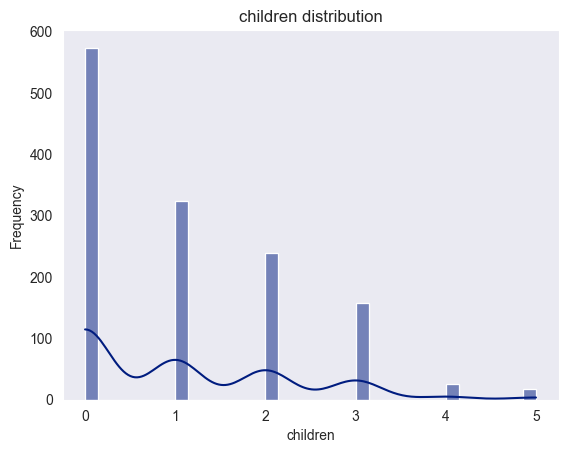

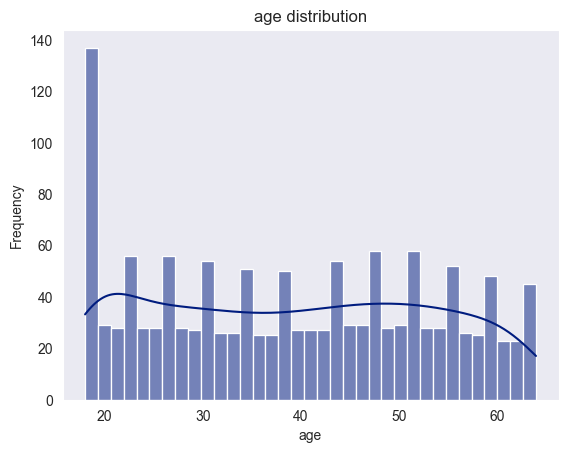

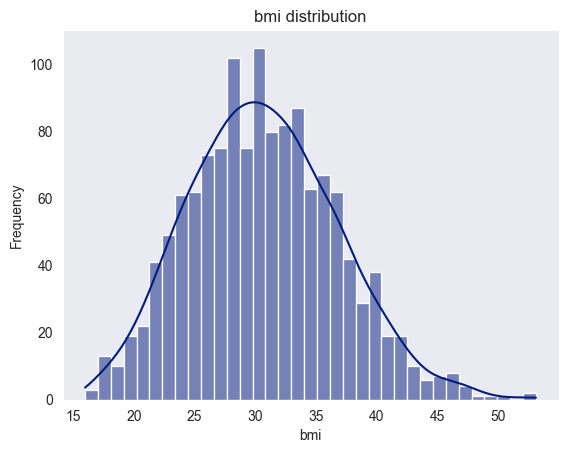

In [26]:
# create histogram and density curves

for col in relevant_num_cols:
    sns.histplot(df[col], kde = True, bins = 35)
    plt.title(f'{col} distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

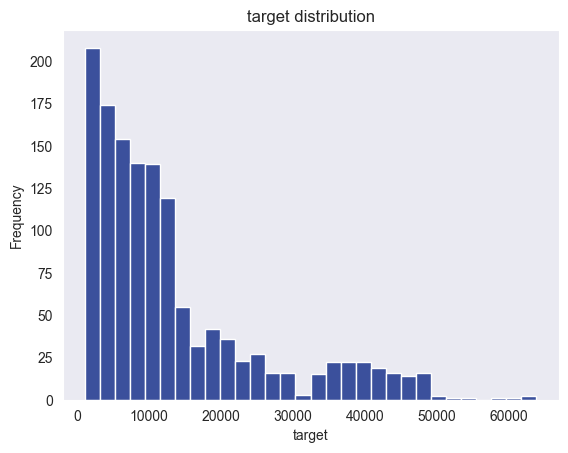

In [27]:
# target feature histogram
sns.histplot(df['target'])
plt.title('target distribution')
plt.xlabel('target')
plt.ylabel('Frequency')
plt.show()

### Box Plots

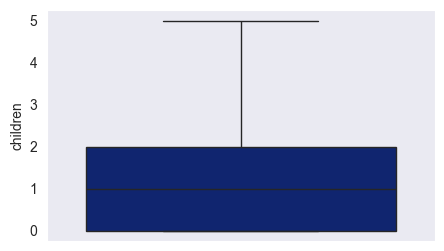

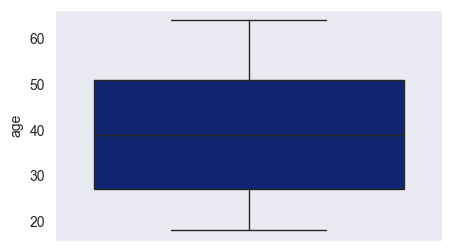

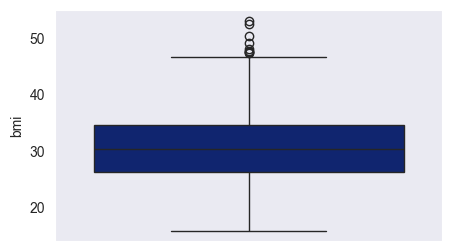

In [28]:
for col in relevant_num_cols:
    plt.figure(figsize = (5, 3))
    sns.boxplot(y = df[col])
    plt.ylabel(col)
    plt.show()

### Pair Plots

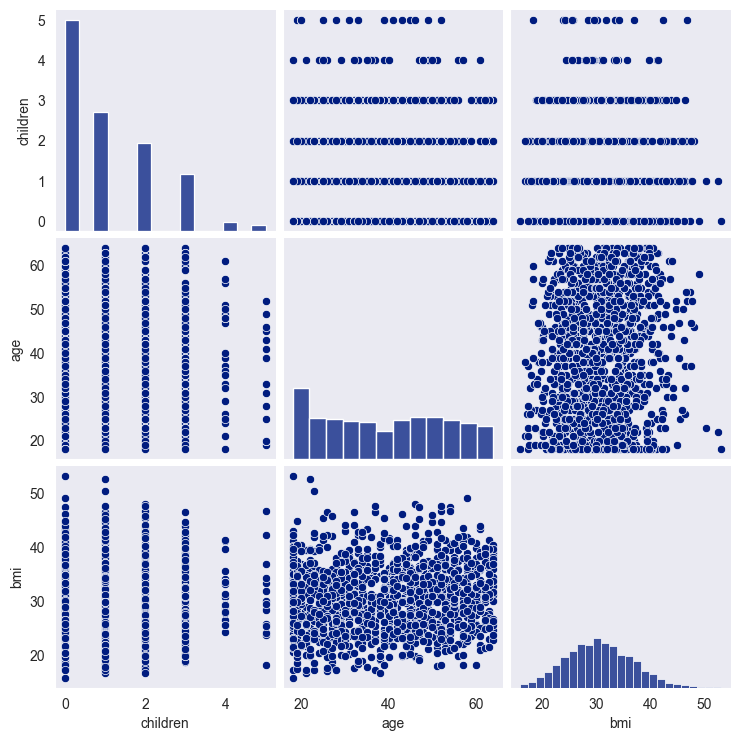

In [29]:
sns.pairplot(df[relevant_num_cols])
plt.show()

### Heatmap

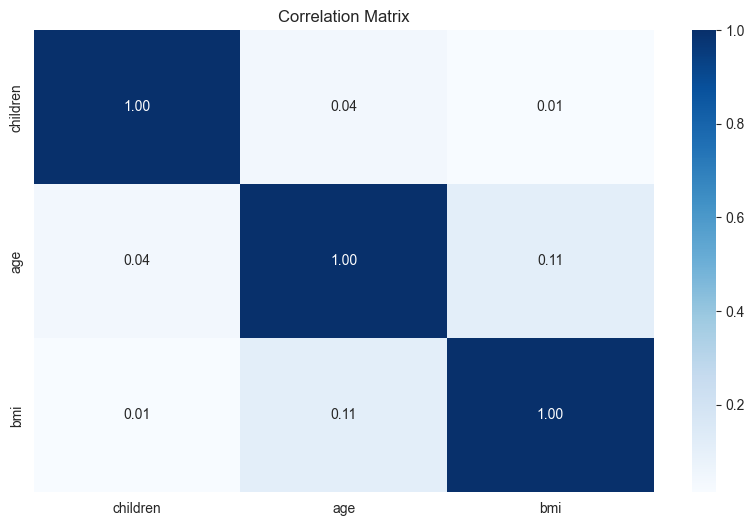

In [30]:
correlation_matrix = df[relevant_num_cols].corr()
plt.figure(figsize = (10, 6))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = 'Blues', cbar = True)
plt.title('Correlation Matrix')
plt.show()

## Categorical Feature Analysis

### Uniqueness

In [31]:
ut.uniqueness_categorical_columns(df, max_categories = 10)

--- Column: sex ---
Unique values: 2


Category,Percentage
male,50.52%
female,49.48%




--- Column: smoker ---
Unique values: 2


Category,Percentage
no,79.52%
yes,20.48%




--- Column: region ---
Unique values: 4


Category,Percentage
southeast,27.20%
southwest,24.29%
northwest,24.29%
northeast,24.22%


### Count Plot

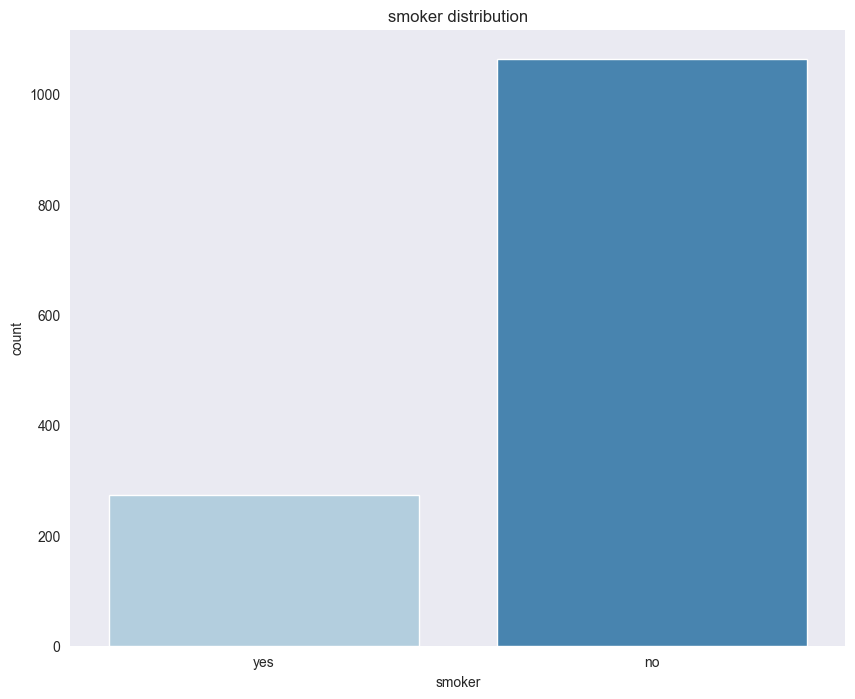

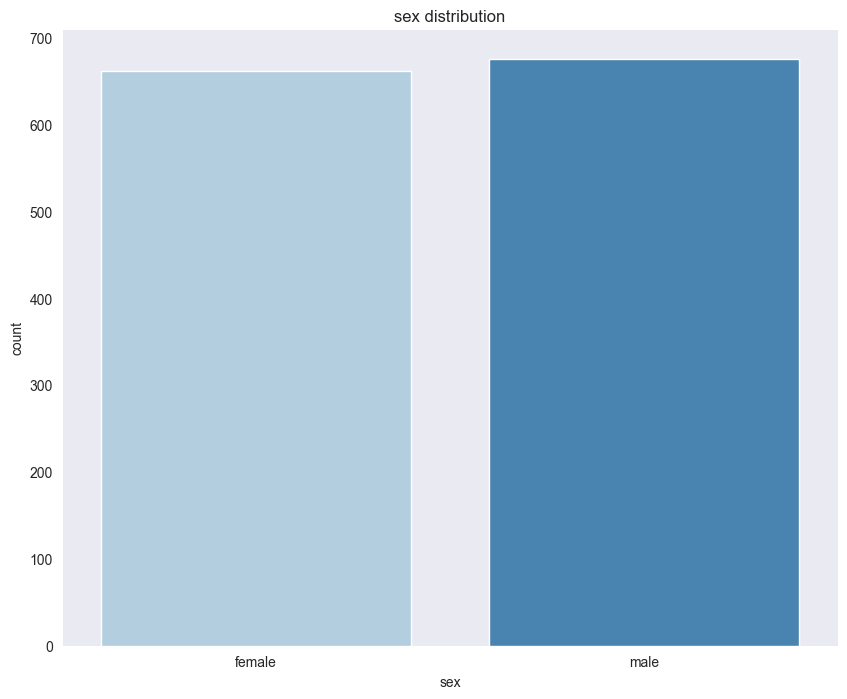

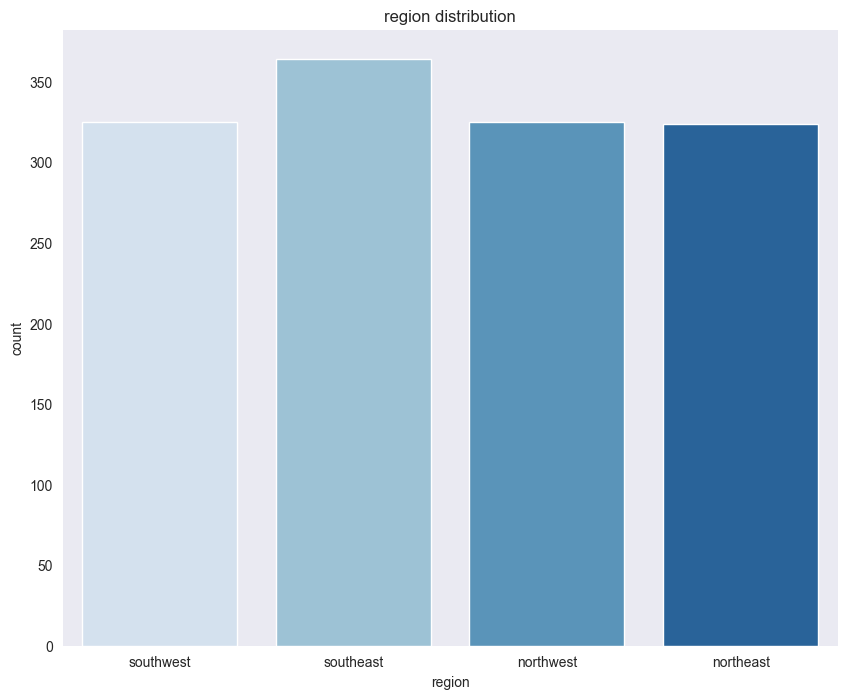

In [32]:
for col in relevant_cat_cols:
    plt.figure(figsize = (10, 8))
    sns.countplot(x = col, data = df, palette = 'Blues', hue = col, legend= False)
    plt.title(f'{col} distribution')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    plt.show()

### Crosstabs

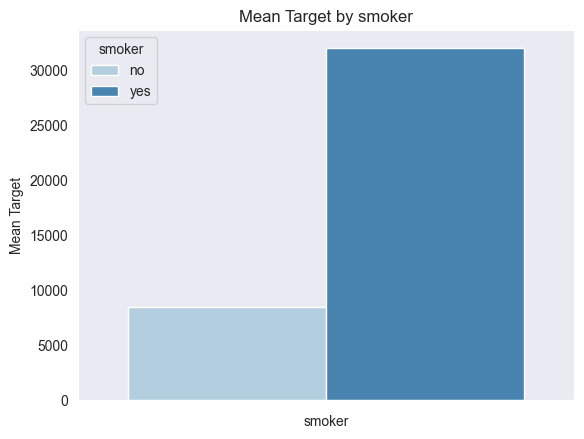

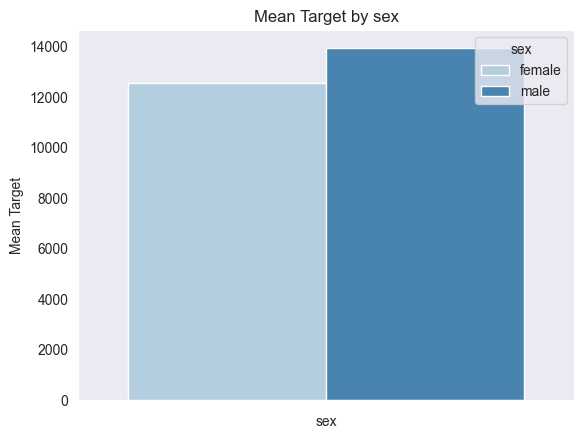

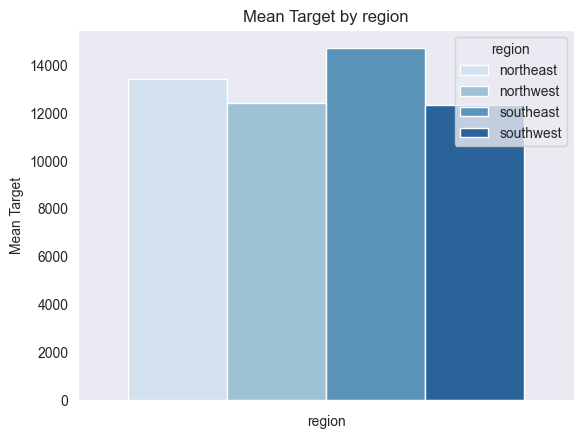

In [35]:
for col in relevant_cat_cols:
    # Calculate the mean of the numeric target grouped by the categorical column
    grouped_stats = df.groupby(col)['target'].mean()

    # Create a bar plot to visualize the aggregated statistics
    sns.barplot(hue=grouped_stats.index, y=grouped_stats.values,legend = True,  palette='Blues')
    plt.title(f'Mean Target by {col}')
    plt.xlabel(col)
    plt.ylabel('Mean Target')
    plt.show()

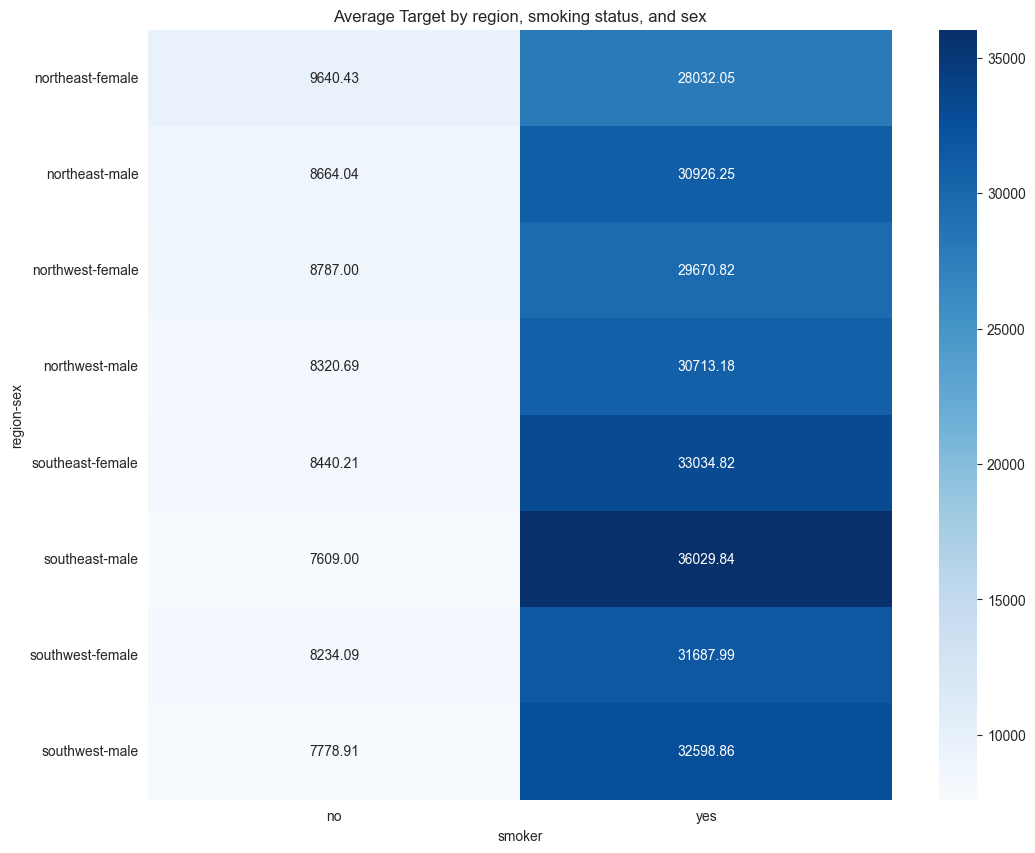

In [37]:
contract_churn = pd.crosstab(
    [df['region'], df['sex']],  # Add more categorical variables for granularity
    df['smoker'],
    values=df['target'],  # Use the target variable for aggregation
    aggfunc='mean'  # Calculate the mean of the target variable
)

plt.figure(figsize=(12, 10))
sns.heatmap(contract_churn, annot=True, fmt='.2f', cmap='Blues')
plt.title('Average Target by region, smoking status, and sex')
plt.show()

## Cross-Variable Feature Analysis

Combines numerical and categorical features to give enhanced insights

### Swarm Plots

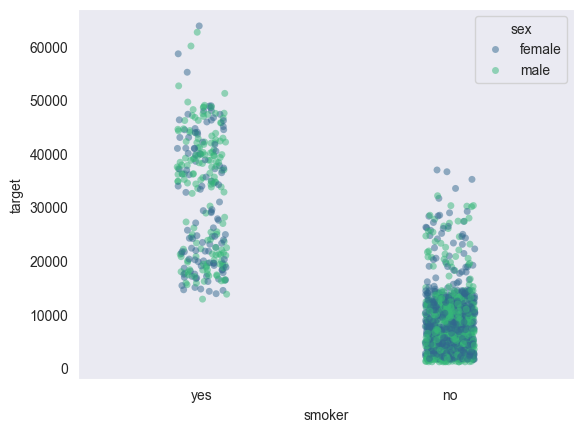

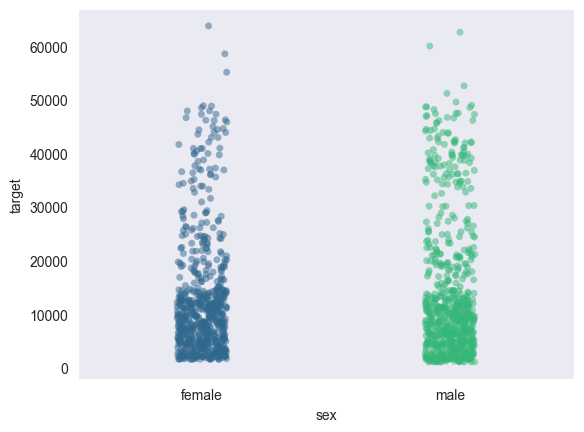

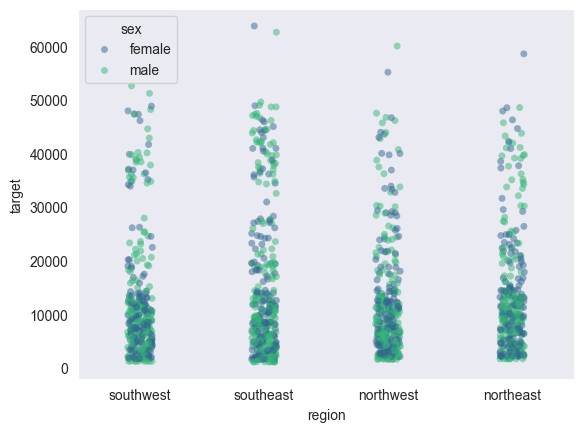

In [38]:
for col in relevant_cat_cols:  
    sns.stripplot(
        x = col, 
        y ='target', # numerical feature
        hue = 'sex',       # target feature
        data = df, 
        size = 5,
        palette = 'viridis',
        alpha = 0.5
        )
    plt.show()

### Scatter Plot

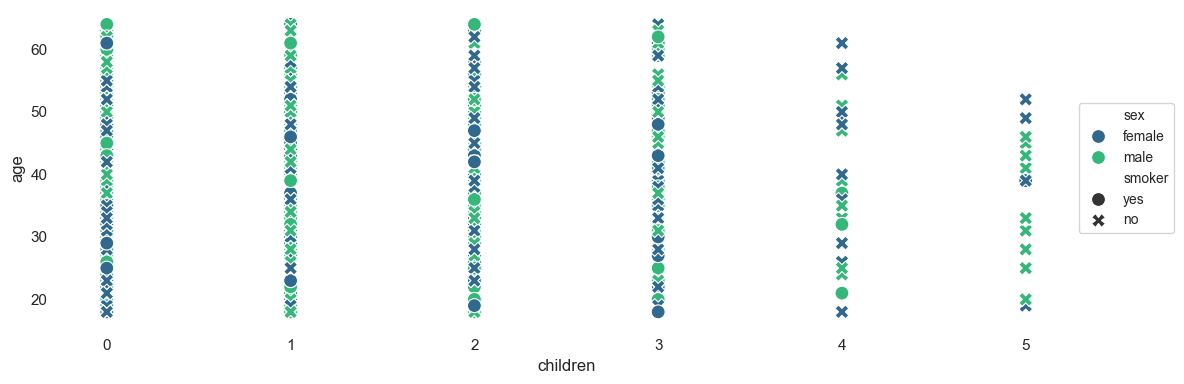

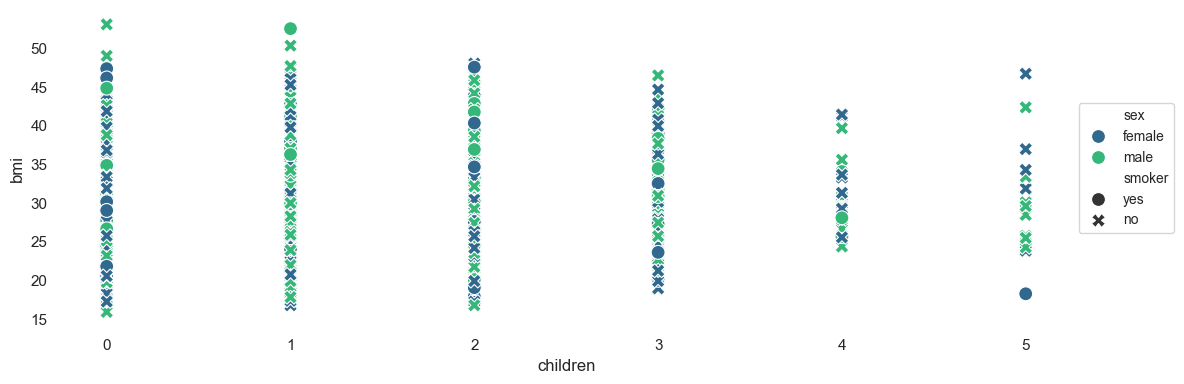

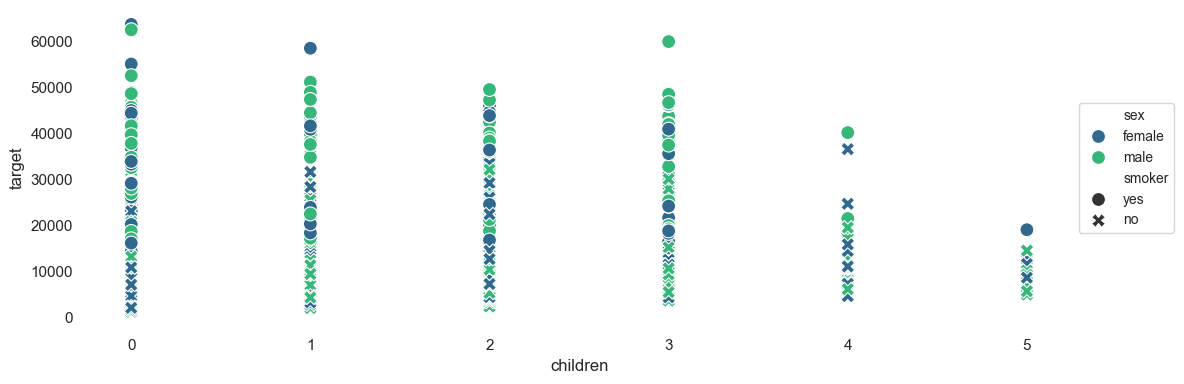

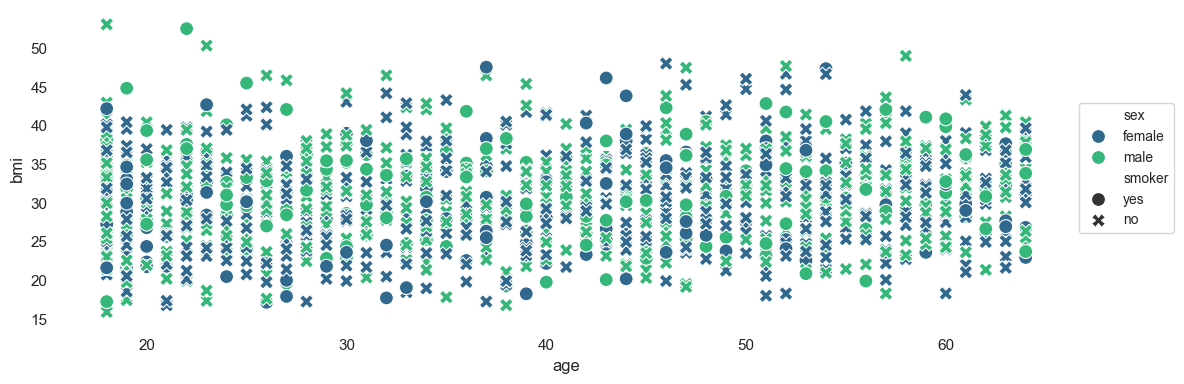

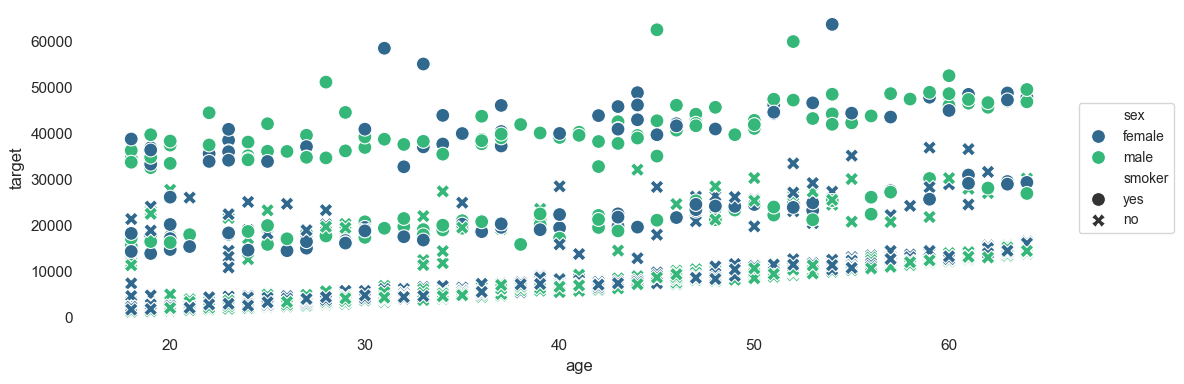

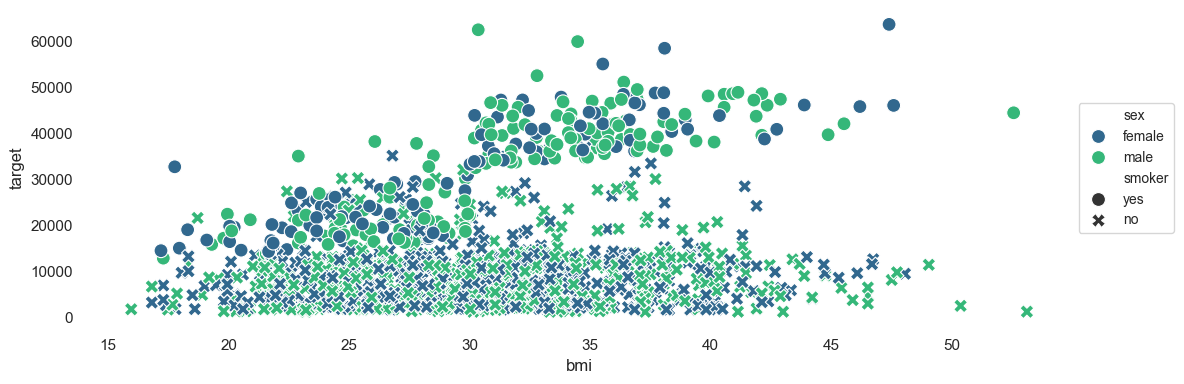

In [41]:
sns.set_theme(style = 'white')

pairs = list(itertools.combinations(relevant_num_cols, 2))

for x_var, y_var in pairs:
    plt.figure(figsize = (12, 4))
    sns.scatterplot(
        x = x_var, 
        y = y_var, 
        hue = 'sex', # categorical
        style = 'smoker', # categorical 
        data = df,
        palette = 'viridis',
        s = 100
        )
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    
    plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

### Categorical Line Plots

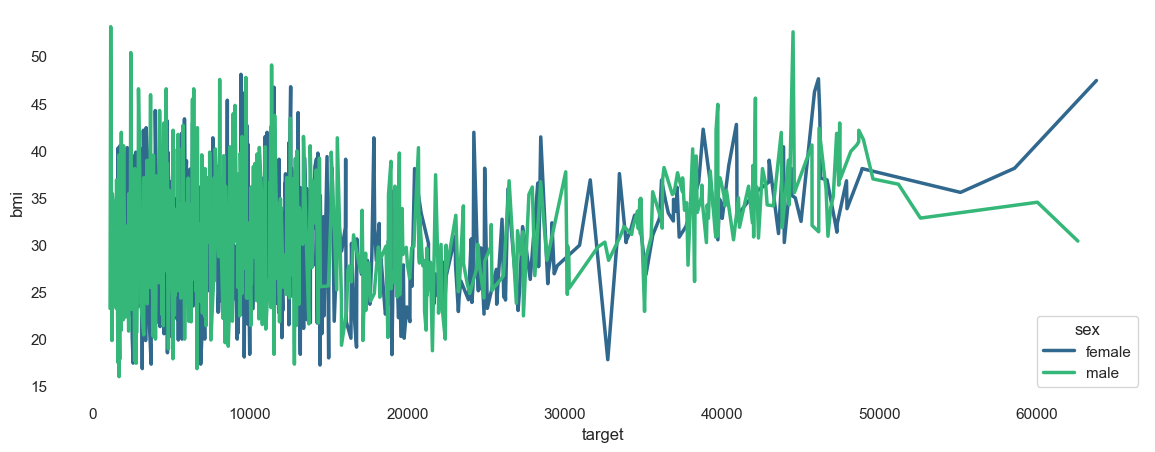

In [42]:
plt.figure(figsize = (14, 5))

sns.lineplot(
    x = 'target', # numerical
    y ='bmi', # numerical
    hue = 'sex', # target
    data = df, 
    errorbar = None,
    palette = 'viridis',
    linewidth = 2.5
    )

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

### Stacked Histograms

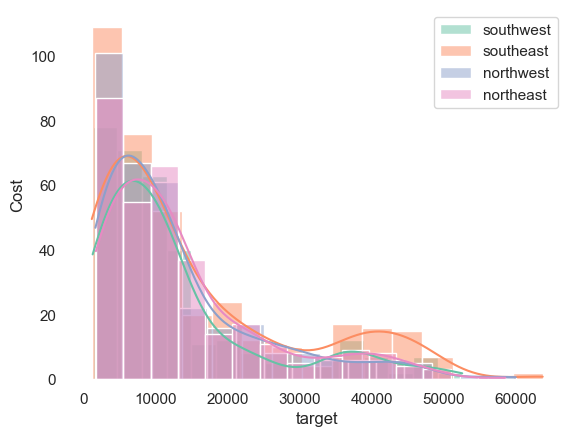

In [44]:
palette = sns.color_palette("Set2", len(df['region'].unique()))  # generates unique color palette

for i, category in enumerate(df['region'].unique()):
    subset = df[df['region'] == category]
    sns.histplot(
        subset['target'], 
        label = category, 
        kde = True, 
        alpha = 0.5,
        bins = 15,
        color = palette[i])
plt.legend()

plt.ylabel('Cost')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

### Interactions Heatmap

#### Mean and Variance Analysis

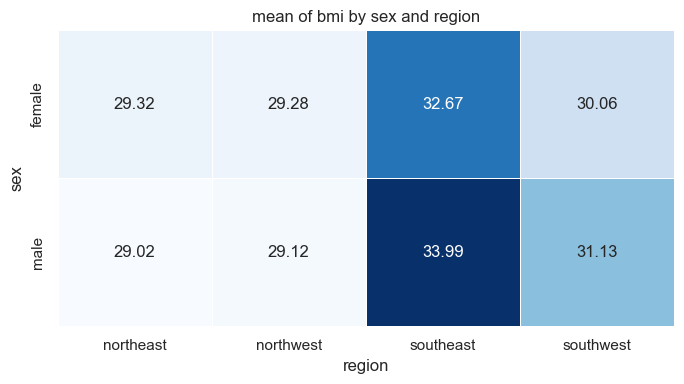

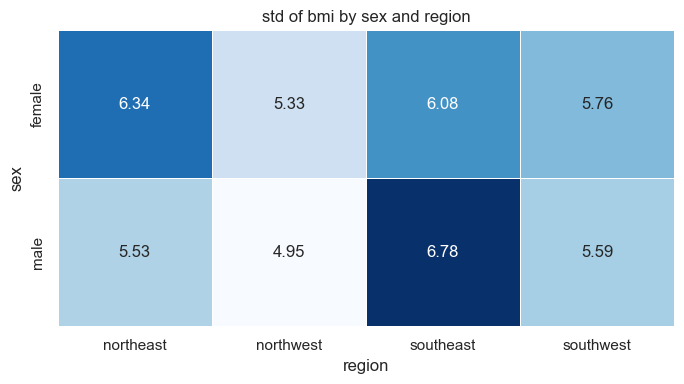

In [45]:
# sex vs region (bmi))
aggregate = ['mean', 'std']

for agg in aggregate:
    pivot_table = pd.pivot_table(
        df,
        values = 'bmi', # numerical
        index = 'sex', # categorical
        columns = 'region', # categorical
        aggfunc = agg   
    )

    plt.figure(figsize = (7, 4))

    sns.heatmap(
        pivot_table, 
        annot = True, 
        fmt = '.2f', 
        linewidths = 0.5,
        cmap = 'Blues',
        cbar = False)

    plt.title(f'{agg} of bmi by sex and region')

    plt.tight_layout()
    plt.show()

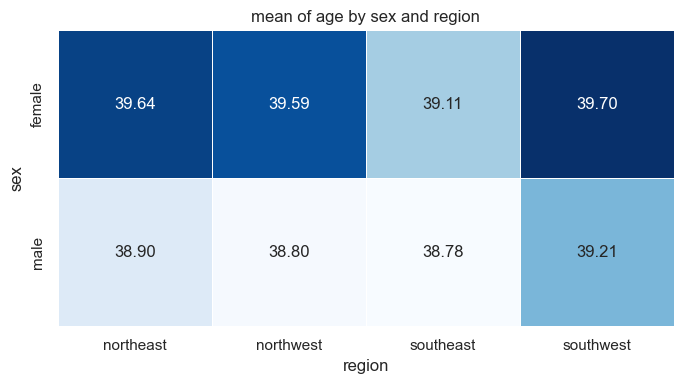

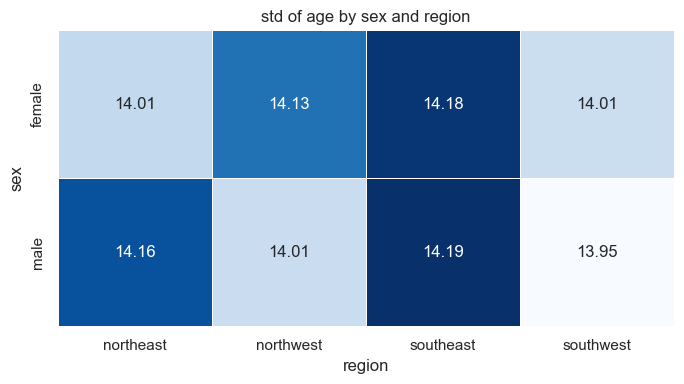

In [54]:
# region vs sex (age)
aggregate = ['mean', 'std']

for agg in aggregate:
    pivot_table = pd.pivot_table(
        df,
        values = 'age', # numerical
        index = 'sex', # categorical
        columns = 'region', # categorical
        aggfunc = agg   
    )

    plt.figure(figsize = (7, 4))

    sns.heatmap(
        pivot_table, 
        annot = True, 
        fmt = '.2f', 
        linewidths = 0.5,
        cmap = 'Blues',
        cbar = False)

    plt.title(f'{agg} of age by sex and region')

    plt.tight_layout()
    plt.show()

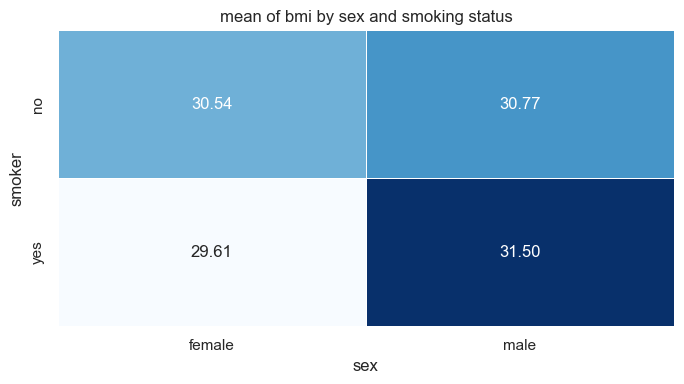

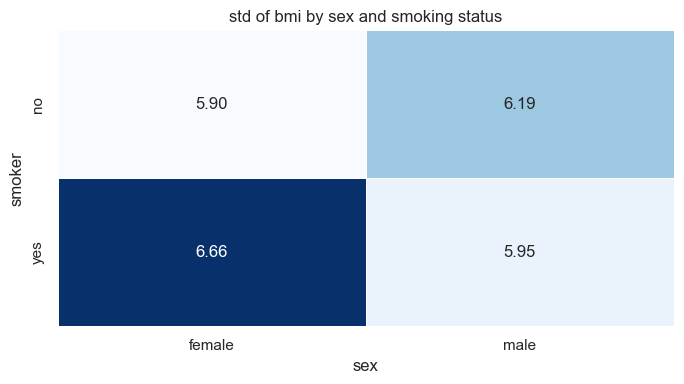

In [55]:
# sex vs smoking status (bmi)
aggregate = ['mean', 'std']

for agg in aggregate:
    pivot_table = pd.pivot_table(
        df,
        values = 'bmi', # numerical
        index = 'smoker', # categorical
        columns = 'sex', # target
        aggfunc = agg   
    )

    plt.figure(figsize = (7, 4))

    sns.heatmap(
        pivot_table, 
        annot = True, 
        fmt = '.2f', 
        linewidths = 0.5,
        cmap = 'Blues',
        cbar = False)

    plt.title(f'{agg} of bmi by sex and smoking status')

    plt.tight_layout()
    plt.show()

#### Min and Max Analysis

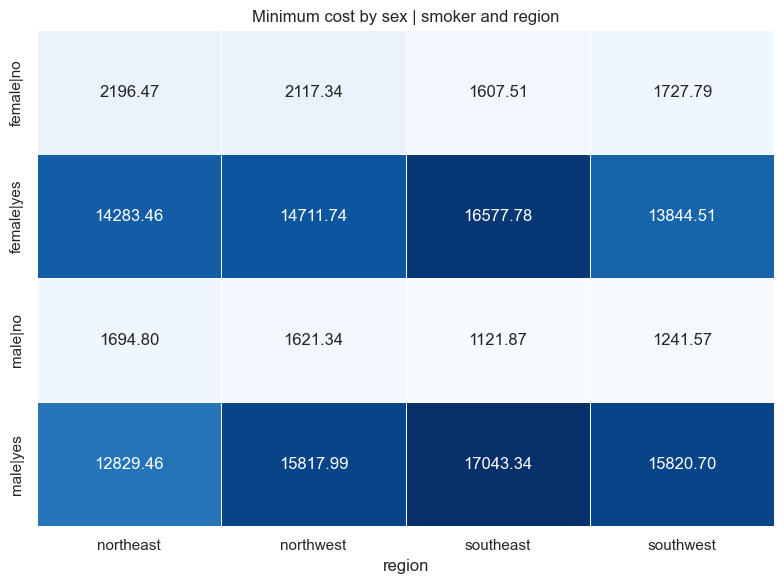

In [57]:
# sex vs smoking status and region (max cost)

combined_index = df['sex'] + '|' + df['smoker'] 
combined_columns = df['region']
pivot_table = pd.pivot_table(
    df,
    values = 'target',
    index = combined_index,
    columns = combined_columns,
    aggfunc = 'min'   
)


plt.figure(figsize = (8, 6))

sns.heatmap(
    pivot_table, 
    annot = True, 
    fmt = '.2f', 
    linewidths = 0.5,
    cmap = 'Blues',
    cbar = False)


plt.title('Minimum cost by sex | smoker and region')

plt.tight_layout()
plt.show()

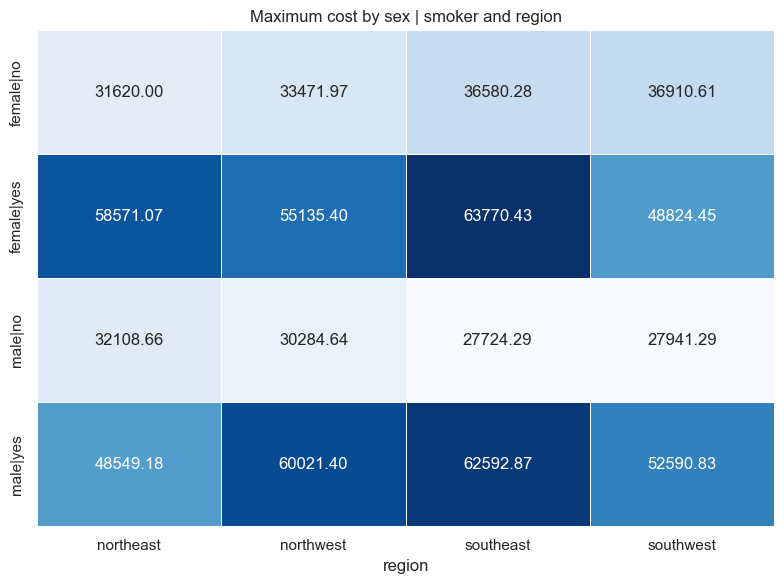

In [58]:
# sex vs smoking status and region (max cost)

combined_index = df['sex'] + '|' + df['smoker'] 
combined_columns = df['region']
pivot_table = pd.pivot_table(
    df,
    values = 'target',
    index = combined_index,
    columns = combined_columns,
    aggfunc = 'max'   
)


plt.figure(figsize = (8, 6))

sns.heatmap(
    pivot_table, 
    annot = True, 
    fmt = '.2f', 
    linewidths = 0.5,
    cmap = 'Blues',
    cbar = False)


plt.title('Maximum cost by sex | smoker and region')

plt.tight_layout()
plt.show()